In [1]:
import torch
import numpy as np
import torchvision.transforms as tt
from torch import nn
from torch.utils.data import  DataLoader, Dataset, ConcatDataset
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from collections import Counter
import torchvision.models as models

В этом блокноте мы поучаствуем в соревновании на Kaggle "Journey to Springfield" и проведем небольшой эксперимент, касающийся результативности нескольких моделей.

In [ ]:
from google.colab import files
files.upload()

Загрузим свой идентификатор с сайта Kaggle для работы с его API

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pwd

/content


In [4]:
!kaggle competitions download -c journey-springfield

 98% 512M/521M [00:08<00:00, 85.7MB/s]
100% 521M/521M [00:08<00:00, 67.2MB/s]


In [5]:
!unzip -q /content/journey-springfield.zip -d journey-springfield

Загрузили и распаковали датасет

Далее нам надо ознакомиться с данными. Посмотрим на распределение классов в тренировочной выборке

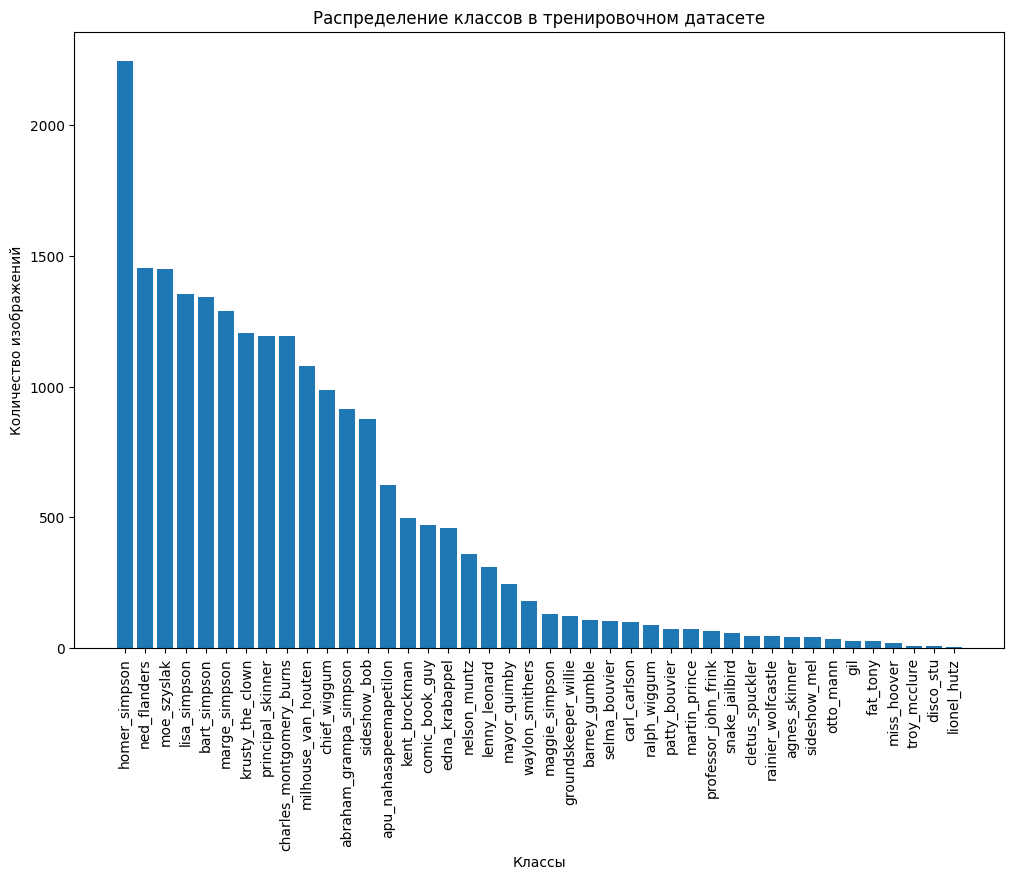

In [6]:
import os
test_path='/content/journey-springfield/testset'
train_path='/content/journey-springfield/train/simpsons_dataset'

classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

class_counts = Counter()
for class_name in classes:
    class_dir = os.path.join(train_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 8))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values())
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.title('Распределение классов в тренировочном датасете')
plt.xticks(rotation=90)
plt.show()

Посмотрим на изображения в датасете

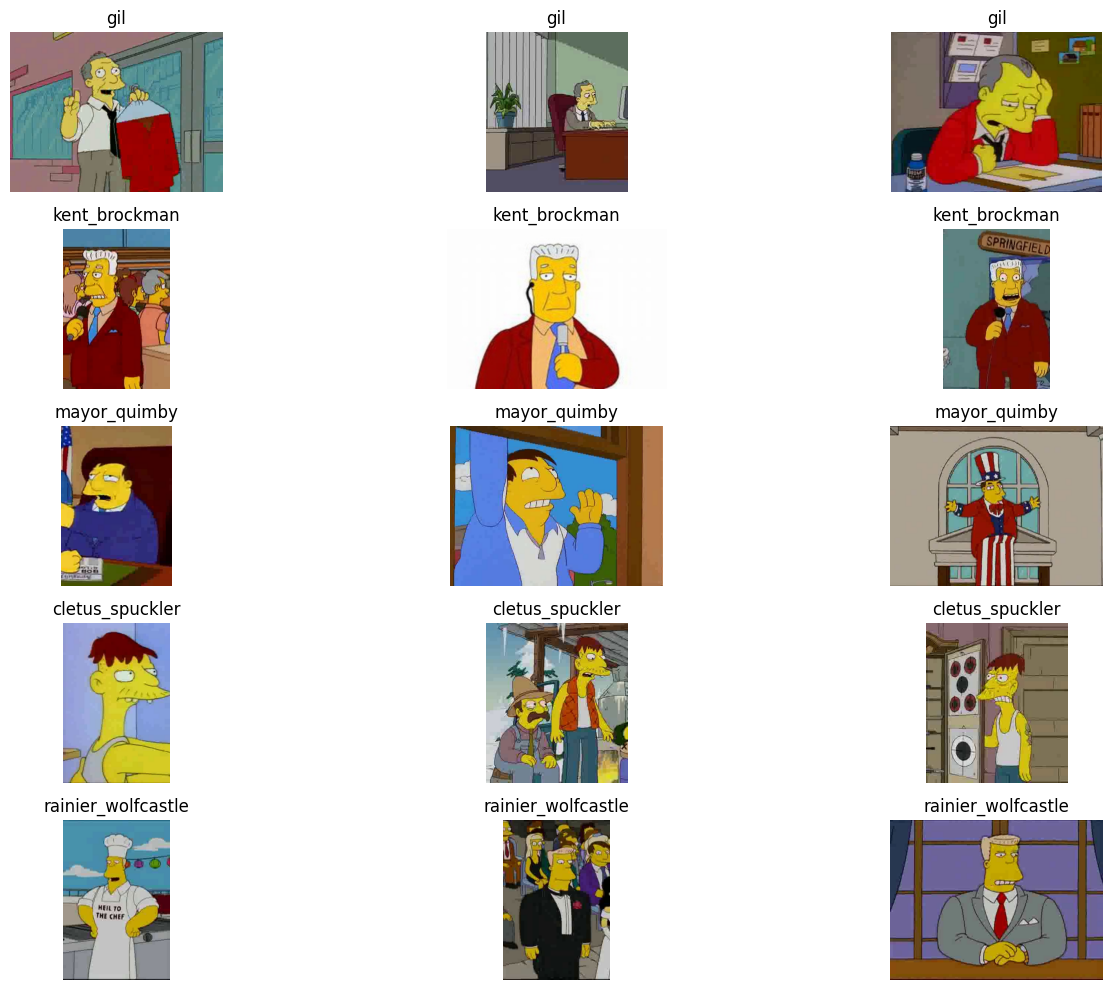

In [7]:
import random
import matplotlib.image as mpimg

num_classes_to_show = 5
num_images_per_class = 3

plt.figure(figsize=(15, 10))

for i, class_name in enumerate(random.sample(classes, num_classes_to_show)):
    class_dir = os.path.join(train_path, class_name)
    images = random.sample(os.listdir(class_dir), num_images_per_class)
    for j, image_name in enumerate(images):
        img_path = os.path.join(class_dir, image_name)
        img = mpimg.imread(img_path)
        plt.subplot(num_classes_to_show, num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)

plt.tight_layout()
plt.show()

Далее проведем предобработку изображений, сделаем resize, приведем к тензору и применим нормализацию

В нашей выборке неравномерное распределение классов, что точно негативно скажется на результатах. Чтобы с этим бороться, нужно сделать так, чтобы в каждом батче, который подается в модель, было более равномерное распределение классов. В этом нам поможет сэмплер, который в соответствии с указанными нами class_weights будет формировать батчи.

Также применим аугментации к тренировочной выборке, что повысит качество модели и разнообразит данные.

In [8]:
trans=tt.Compose([
    tt.Resize(size=(224,224)),
    tt.ToTensor(),
    tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

aug_trans=tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    tt.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    tt.ToTensor(),
    tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_folder=ImageFolder(root=test_path, transform=trans)
train_orig_folder=ImageFolder(root=train_path, transform=trans)
train_aug_folder=ImageFolder(root=train_path, transform=aug_trans)
full_train_folder=ConcatDataset([train_orig_folder,train_aug_folder])

class_labels = [label for _, label in train_orig_folder.samples]
class_counts = Counter(class_labels)
total_samples = len(full_train_folder)
class_weights = [total_samples / (class_counts[class_label] * len(class_counts)) for class_label in class_labels]
sampler = WeightedRandomSampler(class_weights, num_samples=total_samples, replacement=True)

In [9]:
batch_size=64
train_loader = DataLoader(full_train_folder, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_folder, shuffle=False)

Выведем для примера 16 картинок из батча, для того, чтобы убедиться в отсутствии преобладания одного из классов

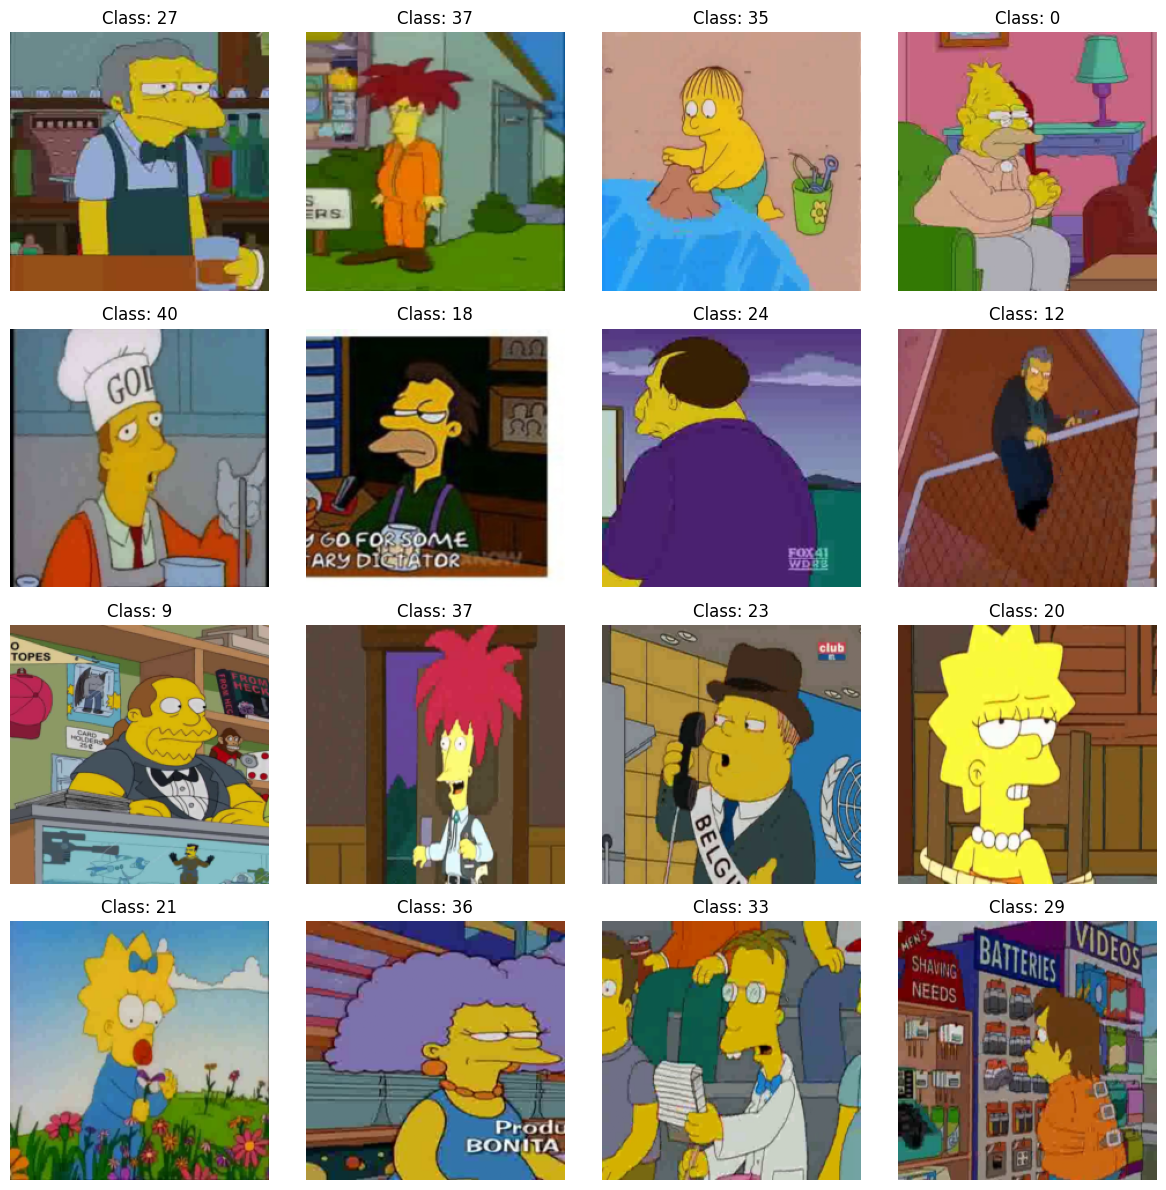

In [10]:
def denormalize(img, mean, std):
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

data_iter = iter(train_loader)
images, labels = next(data_iter)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
images = torch.stack([denormalize(img, mean, std) for img in images])

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()
for img, label, ax in zip(images[:16], labels[:16], axes):
    img = img.permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f'Class: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

В 16 случайных изображениях мы получили 15 разных классов. Так намного лучше!

In [11]:
out_features = len(set(class_labels))
out_features

42

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
from sklearn.metrics import f1_score
from tqdm.autonotebook import tqdm

<ipython-input-13-b79f9cfed1f6>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [14]:
def train(model, optimizer, loss_fn, epochs, lr_scheduler):
    acc_list = []
    loss_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        all_preds = []
        all_labels = []
        model.train()

        for xbatch, ybatch in tqdm(train_loader):
            xbatch, ybatch = xbatch.to(device), ybatch.to(device)
            optimizer.zero_grad()
            outp = model(xbatch)
            loss = loss_fn(outp, ybatch)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outp, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(ybatch.cpu().numpy())

        avg_loss = epoch_loss / len(train_loader)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        loss_list.append(avg_loss)
        acc_list.append(f1)

        lr_scheduler.step()

        print(f'Epoch {epoch + 1}: Train Loss = {avg_loss}, F1 Score = {f1}, lr = {lr_scheduler.get_last_lr()[0]}')

    return acc_list, loss_list

Далее для сравнения возьмём 3 модели:

1) Простая модель с 5 слоями свертки

2) Resnet34, который мы обучим с нуля

3) Предобученный Resnet34, над которым проведем fine-tune

# My simple model

In [15]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [16]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()

simple_cnn = SimpleCnn(out_features).to(device)
optimizer_cnn = torch.optim.AdamW(simple_cnn.parameters(), lr=1e-3, amsgrad=True)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

In [ ]:
simple_cnn_acc, simple_cnn_loss = train(simple_cnn,
                                        optimizer_cnn,
                                        loss_fn,
                                        epochs=15,
                                        lr_scheduler=exp_lr_scheduler)

  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 1: Train Loss = 1.3662159129180982, F1 Score = 0.6471718026530038, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.44017878190706705, F1 Score = 0.8808410397844669, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.29256085223084644, F1 Score = 0.9215606180269043, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.2041298399473192, F1 Score = 0.9436183664625528, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.16147393191958428, F1 Score = 0.9544460462762153, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.12487493489463707, F1 Score = 0.9656760075288773, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.10742691703823232, F1 Score = 0.9697348501491954, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.05732790514727244, F1 Score = 0.9851548028416527, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.044507286688561715, F1 Score = 0.9883152955238992, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.03443952204209916, F1 Score = 0.9918498707560677, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.032107041254088656, F1 Score = 0.9920351388361868, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.027729427534598103, F1 Score = 0.9936029675014107, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 13: Train Loss = 0.022276848113032783, F1 Score = 0.994869794877841, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 14: Train Loss = 0.020718721237884725, F1 Score = 0.9952058397179555, lr = 1e-05


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 15: Train Loss = 0.01954832652171377, F1 Score = 0.9957076893812298, lr = 1e-05


In [ ]:
torch.save(simple_cnn.state_dict(), 'simple_cnn.pth')

#ResNet34

In [19]:
resnet34 = models.resnet34(pretrained=False)
resnet34.fc = nn.Linear(resnet34.fc.in_features, out_features)
resnet34 = resnet34.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
resnet34_pretrained = models.resnet34(pretrained=True)
for param in resnet34_pretrained.parameters():
    param.requires_grad = False
resnet34_pretrained.fc = nn.Linear(resnet34_pretrained.fc.in_features, out_features)
for param in list(resnet34_pretrained.parameters())[-10:]:
    param.requires_grad = True
resnet34_pretrained = resnet34_pretrained.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 138MB/s]


In [21]:
optimizer_resnet = torch.optim.AdamW(resnet34.parameters(), lr=1e-3, amsgrad=True)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

In [ ]:
resnet_acc, resnet_loss = train(resnet34,
                                optimizer_resnet,
                                loss_fn,
                                epochs=15,
                                lr_scheduler=exp_lr_scheduler)

  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 1: Train Loss = 1.6416982323613785, F1 Score = 0.5487948216969463, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.4213220973961226, F1 Score = 0.8816020859467943, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.2143047832379132, F1 Score = 0.9389912311916024, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.13192803109960474, F1 Score = 0.9616244207278037, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.08611184637531467, F1 Score = 0.9758556039990072, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.06080668503720711, F1 Score = 0.983164239148867, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.05256395457092075, F1 Score = 0.9856958764894427, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.021330773507738984, F1 Score = 0.9950003283667801, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.01460236612221276, F1 Score = 0.9970348127091483, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.01120080170506, F1 Score = 0.9978967981549388, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.009122418787397928, F1 Score = 0.9979688746990634, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.006949433589861586, F1 Score = 0.9985657822888256, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 13: Train Loss = 0.006853957969263438, F1 Score = 0.9986619783263824, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 14: Train Loss = 0.005336565559530873, F1 Score = 0.9991634301747601, lr = 1e-05


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 15: Train Loss = 0.004800459492830773, F1 Score = 0.9992830319823808, lr = 1e-05


In [ ]:
torch.save(resnet34.state_dict(), 'resnet34.pth')

In [22]:
optimizer_resnet_pre = torch.optim.AdamW(resnet34_pretrained.parameters(), lr=1e-3, amsgrad=True)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_resnet_pre, step_size=7, gamma=0.1)

In [23]:
resnet_pre_acc, resnet_pre_loss = train(resnet34_pretrained,
                                        optimizer_resnet_pre,
                                        loss_fn,
                                        epochs=15,
                                        lr_scheduler=exp_lr_scheduler)

  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3128957220872167, F1 Score = 0.9266322584396819, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.06981895750687095, F1 Score = 0.9829217299323157, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.03723592077389018, F1 Score = 0.990742566988862, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.023541412261165393, F1 Score = 0.9945040598825282, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.017817981504099373, F1 Score = 0.9953855547631018, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.01181557038607865, F1 Score = 0.9973007476744898, lr = 0.001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.0073692761844144925, F1 Score = 0.9982792326587943, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.003921020134260615, F1 Score = 0.9993550583208938, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.0024957230498788537, F1 Score = 0.9995939260232056, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.0017120149512002102, F1 Score = 0.9997372587251188, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.0010980935409937928, F1 Score = 0.9999761141898063, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.001238057285203787, F1 Score = 0.9998327867590545, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 13: Train Loss = 0.0011729891724548594, F1 Score = 0.9999283401006687, lr = 0.0001


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 14: Train Loss = 0.0007797225424108977, F1 Score = 0.9999761141689264, lr = 1e-05


  0%|          | 0/655 [00:00<?, ?it/s]

Epoch 15: Train Loss = 0.0008260533464219393, F1 Score = 0.9999761144030097, lr = 1e-05


In [24]:
torch.save(resnet34_pretrained.state_dict(), 'resnet34_pretrained.pth')

#Comparition

Когда все модели обучены, выведем графики точности и потерь, для визуализации процесса их обучения

In [ ]:
resnet_l = [x.to('cpu').detach().numpy() for x in resnet_loss]
resnet_a = [x.to('cpu').detach().numpy() for x in resnet_acc]

resnet_pre_l = [x.to('cpu').detach().numpy() for x in resnet_pre_loss]
resnet_pre_a = [x.to('cpu').detach().numpy() for x in resnet_pre_acc]

simple_cnn_l = [x.to('cpu').detach().numpy() for x in simple_cnn_loss]
simple_cnn_a = [x.to('cpu').detach().numpy() for x in simple_cnn_acc]

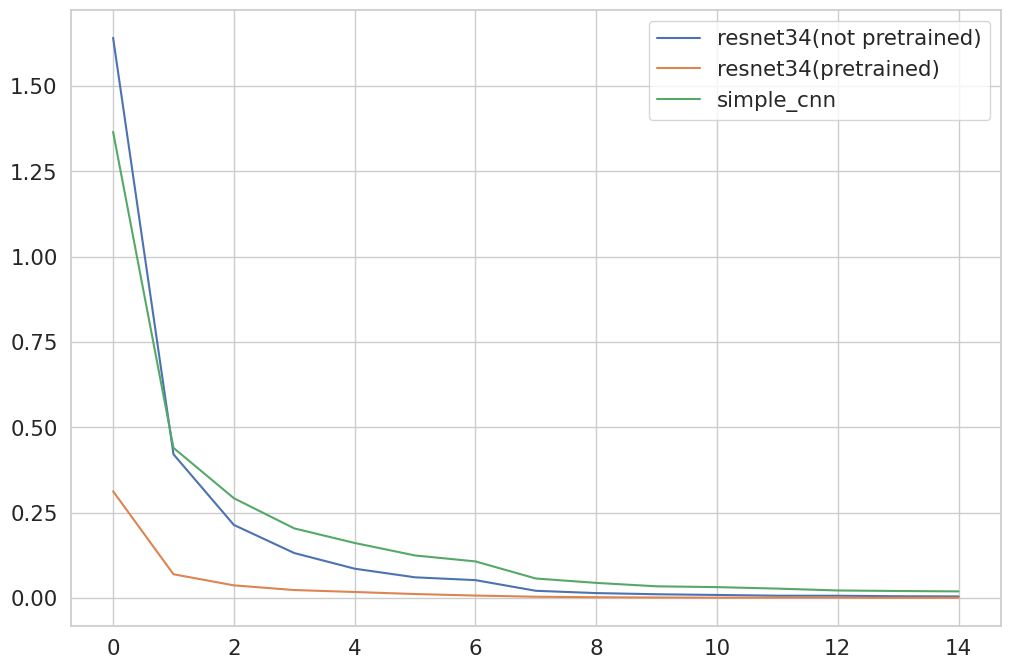

In [28]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(12, 8))
plt.plot(resnet_l, label="resnet34(not pretrained)")
plt.plot(resnet_pre_l, label="resnet34(pretrained)")
plt.plot(simple_cnn_l, label="simple_cnn")
plt.legend()
plt.show()

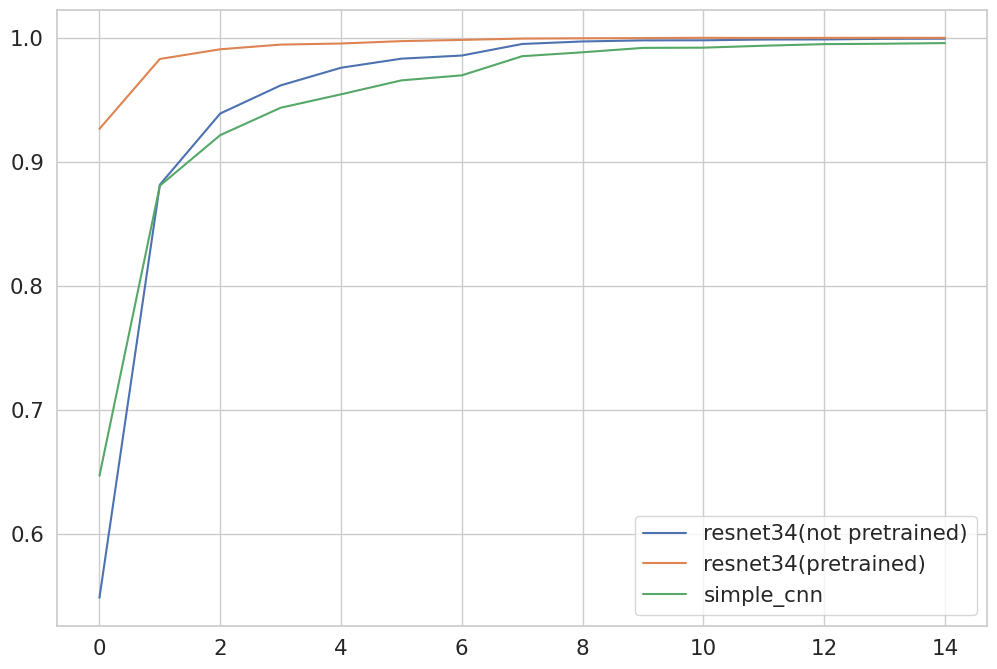

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(resnet_a, label="resnet34(not pretrained)")
plt.plot(resnet_pre_a, label="resnet34(pretrained)")
plt.plot(simple_cnn_a, label="simple_cnn")
plt.legend()
plt.show()

Как мы видим, предобученный Resnet сошелся намного быстрее.

Сделаем предсказания наших моделей на тестовой выборке и отправим результаты на Kaggle

In [30]:
simple_cnn.load_state_dict(torch.load('simple_cnn.pth'))

<All keys matched successfully>

In [31]:
y_test = []

simple_cnn.eval()
with torch.inference_mode():

  for xb, yb in test_loader:

    xb, yb = xb.to(device), yb.to(device)

    batch_logits = simple_cnn(xb)
    predictions = F.softmax(batch_logits, dim=-1)
    predictions = predictions.argmax(-1)
    y_test.append(predictions.item())

from pathlib import Path
import pandas as pd

test_folder = '/content/journey-springfield/testset/testset'
test_path = 'testset/testset'
test_files = sorted(list(Path(test_folder).rglob('*.jpg')))
preds = y_test

submit = pd.DataFrame(columns=['Id'])

test_filenames = [path.name for path in test_files]
submit['Id'] = test_filenames
submit['Expected'] = [train_orig_folder.classes[pred] for pred in preds]
submit.sort_values(by=['Id'])
submit.to_csv('submission.csv', index=False)

submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


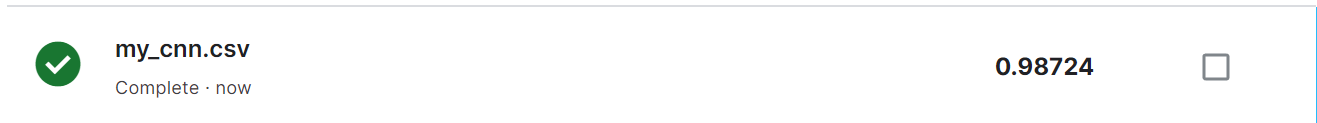

In [ ]:
resnet34.load_state_dict(torch.load('resnet34.pth'))

<All keys matched successfully>

In [ ]:
y_test = []

resnet34.eval()
with torch.inference_mode():

  for xb, yb in test_loader:

    xb, yb = xb.to(device), yb.to(device)

    batch_logits = resnet34(xb)
    predictions = F.softmax(batch_logits, dim=-1)
    predictions = predictions.argmax(-1)
    y_test.append(predictions.item())


test_folder = '/content/journey-springfield/testset/testset'
test_path = 'testset/testset'
test_files = sorted(list(Path(test_folder).rglob('*.jpg')))
preds = y_test

submit = pd.DataFrame(columns=['Id'])

test_filenames = [path.name for path in test_files]
submit['Id'] = test_filenames
submit['Expected'] = [train_orig_folder.classes[pred] for pred in preds]
submit.sort_values(by=['Id'])
submit.to_csv('submission.csv', index=False)

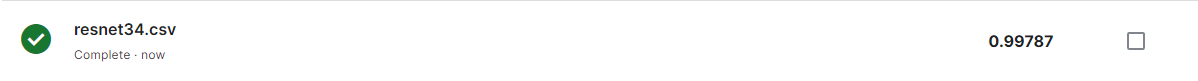

In [ ]:
resnet34_pretrained.load_state_dict(torch.load('resnet34_pretrained.pth'))

<All keys matched successfully>

In [32]:
y_test = []

resnet34_pretrained.eval()
with torch.inference_mode():

  for xb, yb in test_loader:

    xb, yb = xb.to(device), yb.to(device)

    batch_logits = resnet34_pretrained(xb)
    predictions = F.softmax(batch_logits, dim=-1)
    predictions = predictions.argmax(-1)
    y_test.append(predictions.item())


test_folder = '/content/journey-springfield/testset/testset'
test_path = 'testset/testset'
test_files = sorted(list(Path(test_folder).rglob('*.jpg')))
preds = y_test

submit = pd.DataFrame(columns=['Id'])

test_filenames = [path.name for path in test_files]
submit['Id'] = test_filenames
submit['Expected'] = [train_orig_folder.classes[pred] for pred in preds]
submit.sort_values(by=['Id'])
submit.to_csv('submission.csv', index=False)

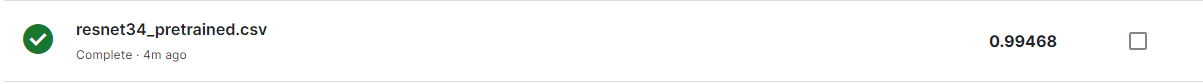